In [24]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np

In [25]:
from utils import *

In [26]:
data_dir = "data/mit-bih-arrhythmia-database-1.0.0/"
record_name = "101"

rec = read_record(f"{data_dir}{record_name}")

In [27]:
sig = rec.p_signal
ann = read_annotation(f"{data_dir}{record_name}")

# sig = sig - sig.mean()  # Normalize

High pass filter to remove noise

In [28]:
from scipy.signal import butter, lfilter

def apply_high_pass_filter(signal, cutoff_freq, fs, order=4):
    """
    Applies a high-pass Butterworth filter to the signal.
    
    Parameters:
    - signal: Input ECG signal (1D array).
    - cutoff_freq: Cutoff frequency of the filter in Hz.
    - fs: Sampling frequency of the signal in Hz.
    - order: Order of the Butterworth filter (default is 4).
    
    Returns:
    - filtered_signal: Signal after high-pass filtering.
    """
    # Normalize the cutoff frequency to the Nyquist frequency
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist

    # Design the Butterworth high-pass filter
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)

    filtered_signal = lfilter(b, a, signal)

    return filtered_signal


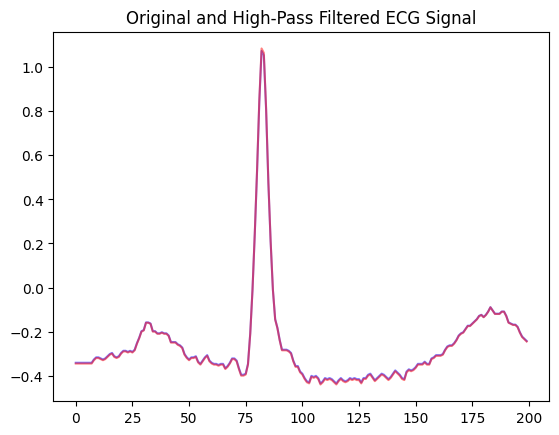

In [29]:

orig_sig = sig.copy()   
sig = apply_high_pass_filter(sig, 0.6, rec.fs, order=3)

# Plot the signal
plt.plot(sig[:200, 0], alpha=0.5, c="b")
plt.plot(orig_sig[:200, 0], alpha=0.5, c="r")
plt.title("Original and High-Pass Filtered ECG Signal")
# Plot the annotations
plt.show()

In [ ]:
sample_len = len(sig)

fs = rec.fs  # Sampling frequency
signal = sig[:sample_len, 0]  # Example signal

# Step 1: Apply the Haar-like matched filter
fil = create_haar_like_filter(fs)
delay_smp, delay_time = calculate_convolution_delay(fil, fs)

print("Signal delayed by", delay_smp, "samples.")

filtered_signal = apply_matched_filter(signal, fs)
# filtered_signal = filtered_signal / np.max(filtered_signal)                 # Normalize the filtered signal
filtered_signal = [0 for i in range(delay_smp)] + list(filtered_signal)     # Add delay to the filtered signal
filtered_signal = filtered_signal[:sample_len]                                    # Truncate the filtered signal
filtered_signal = np.array(filtered_signal)

# Step 2: Calculate the second-order difference
second_diff = second_order_difference(signal)

# Step 3: Calculate the score function
score = calculate_score(second_diff, filtered_signal, second_diff)

# Step 4: Sift R-wave candidates
# r_wave_candidates = sift_r_wave_candidates(score, fs, threshold=np.max(score)/150)
r_wave_candidates = sift_r_wave_candidates_dynamic(score, fs, percentile=80, min_value=np.max(score)/50)

# Output results
print("Filtered Signal:", filtered_signal)
print("Second-Order Difference:", second_diff)
print("Score Function:", score)
print("R-wave Peak Candidates (indices):", r_wave_candidates)
print(max(score))


Signal delayed by 21 samples.
Filtered Signal: [0.         0.         0.         ... 0.21458318 0.21458318 0.59947873]
Second-Order Difference: [ 0.          0.          0.         ... -0.00494791 -0.28203105
  0.        ]
Score Function: [ 0.          0.          0.         ... -0.0016457  -0.09380463
  0.        ]
R-wave Peak Candidates (indices): [83, 396, 711, 1033, 1369, 1712, 2036, 2349, 2662, 2972, 3301, 3630, 3960, 4283, 4609, 4928, 5240, 5568, 5898, 6223, 6528, 6830, 7142, 7462, 7785, 8105, 8414, 8721, 9026, 9320, 9628, 9953, 10281, 10590, 10892, 11185, 11307, 11474, 11760, 12050, 12338, 12621, 12911, 13184, 13457, 13740, 14030, 14333, 14640, 14743, 14923, 15195, 15474, 15760, 16051, 16351, 16655, 16956, 17250, 17532, 17814, 18099, 18396, 18687, 18976, 19267, 19558, 19860, 20173, 20494, 20822, 21166, 21499, 21809, 22130, 22451, 22782, 23127, 23457, 23775, 24090, 24404, 24720, 25040, 25373, 25704, 26008, 26310, 26637, 26967, 27303, 27622, 27934, 28243, 28558, 28861, 29155, 2946

In [31]:
len(r_wave_candidates), np.max(score)/10

(1880, 1.3248618233063767)

Adaptive Threshold: 1.3901578219815454


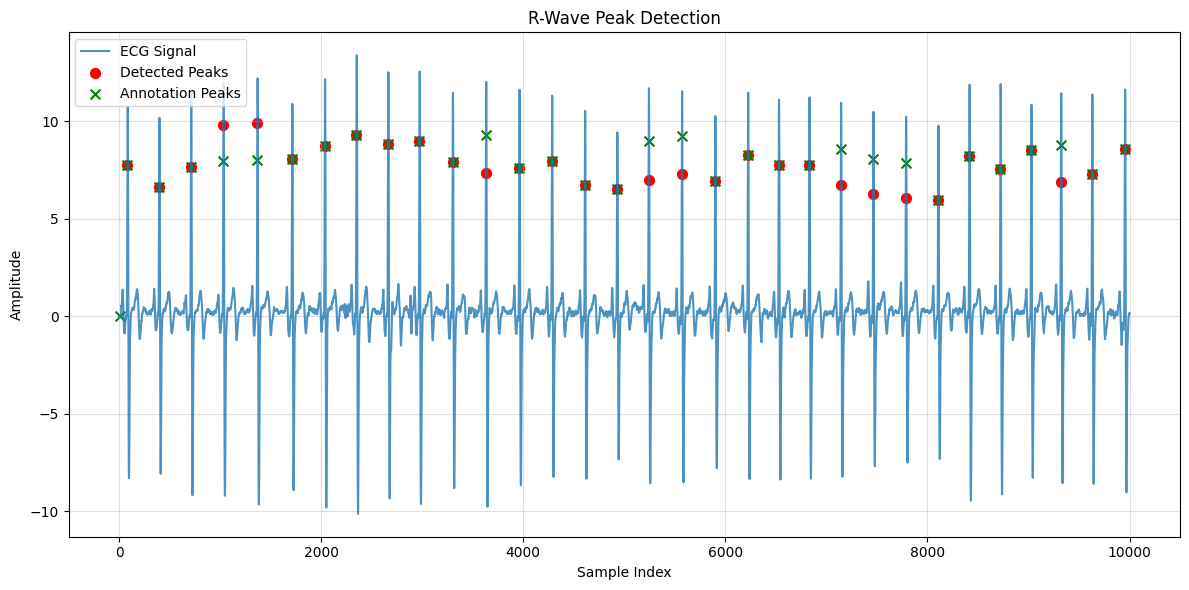

1866

In [32]:
# Compute the adaptive threshold and refine candidates
refined_r_wave_candidates = refine_r_wave_candidates(
    score, r_wave_candidates, fs, 
    lambda score, peaks, fs: calculate_adaptive_threshold(score, peaks, fs, T=.3, beta1=.025, beta2=.025)
)
lim = 10_000
plot_detected_peaks(filtered_signal[:lim], refined_r_wave_candidates, fs, ann.sample[:len(refined_r_wave_candidates)])
len(refined_r_wave_candidates)

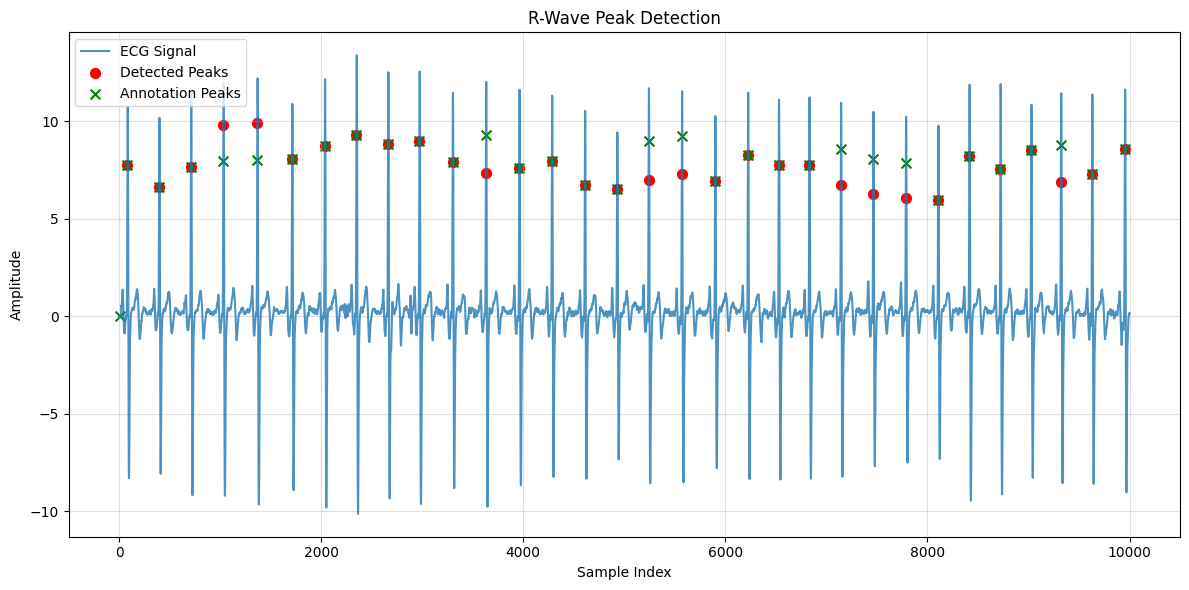

In [33]:
plot_detected_peaks(filtered_signal[:lim], r_wave_candidates, fs, ann.sample[:len(refined_r_wave_candidates)])


[83, 396, 711, 1033, 1369, 1712, 2036, 2349, 2662, 2972, 3301, 3630, 3960, 4283, 4609, 4928, 5240, 5568, 5898, 6223, 6528, 6830, 7142, 7462, 7785, 8105, 8414, 8721, 9026, 9320, 9628, 9953, 10281, 10590, 10892, 11185, 11474, 11760, 12050, 12338, 12621, 12911, 13184, 13457, 13740, 14030, 14333, 14640, 14923, 15195, 15474, 15760, 16051, 16351, 16655, 16956, 17250, 17532, 17814, 18099, 18396, 18687, 18976, 19267, 19558, 19860, 20173, 20494, 20822, 21166, 21499, 21809, 22130, 22451, 22782, 23127, 23457, 23775, 24090, 24404, 24720, 25040, 25373, 25704, 26008, 26310, 26637, 26967, 27303, 27622, 27934, 28243, 28558, 28861, 29155, 29467, 29782, 30088, 30387, 30688, 30985, 31310, 31635, 31947, 32262, 32566, 32867, 33169, 33471, 34395, 34683, 34984, 35293, 35598, 35912, 36217, 36529, 36836, 37140, 37449, 37772, 38099, 38429, 38748, 39058, 39375, 39691, 40013, 40339, 40668, 41264, 41542, 41829, 42125, 42421, 42714, 42990, 43268, 43546, 43817, 44095, 44388, 44676, 44977, 45269, 45553, 45840, 46138,

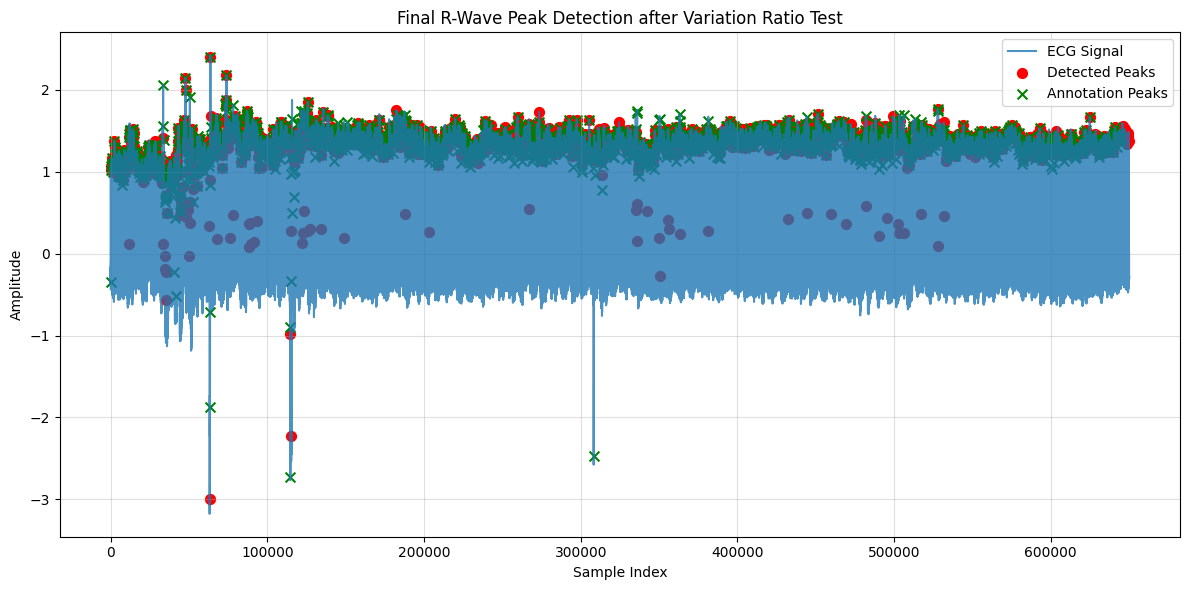

In [34]:

# Perform Variation Ratio Test
refined_peaks_variation_test = variation_ratio_test(
    signal=signal, 
    peak_candidates=refined_r_wave_candidates, 
    fs=fs, 
    window=0.2,
    threshold=0.2
)


print(refined_peaks_variation_test)

# Plot the final detected peaks
plot_detected_peaks(
    signal=orig_sig[:,0], 
    peak_indices=refined_peaks_variation_test,
    fs=fs, 
    ann=ann.sample[:len(refined_peaks_variation_test)+1], 
    title="Final R-Wave Peak Detection after Variation Ratio Test"
)


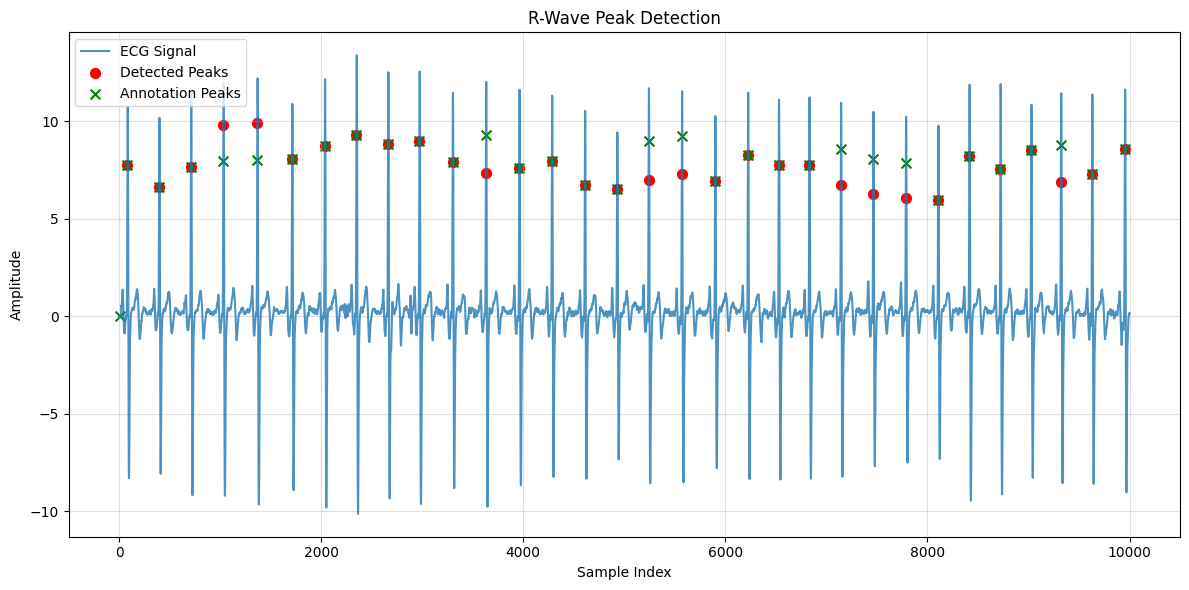

In [35]:
plot_detected_peaks(filtered_signal[:lim], refined_peaks_variation_test, fs, ann.sample[:len(refined_r_wave_candidates)])

In [36]:
len(ann.sample), len(sig[ann.sample]), sig[ann.sample]

(1874,
 1874,
 array([[-0.341406  , -0.15118286],
        [ 1.05390549, -0.39316633],
        [ 1.00937427, -0.33780663],
        ...,
        [ 1.42499897, -0.10901158],
        [ 1.37551984, -0.16240234],
        [ 1.35572819, -0.18672739]]))

In [37]:
def sensitivity(tp, fn):
    """
    Calculate the Sensitivity (SE) metric.
    
    SE = TP / (TP + FN)
    """
    return (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0  # Avoid division by zero


def positive_prediction(tp, fp):
    """
    Calculate the Positive Prediction (+P) metric.
    
    +P = TP / (TP + FP)
    """
    return (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0  # Avoid division by zero


def detection_error_rate(tp, fn, fp):
    """
    Calculate the Detection Error Rate (DER) metric.
    
    DER = (FP + FN) / (TP + FN)
    """
    return ((fp + fn) / (tp + fn)) * 100 if (tp + fn) > 0 else 0  # Avoid division by zero

In [38]:
def get_metrics(labels, detections, offset_threshold):
    """
    Calculate the performance metrics (Sensitivity, Positive Prediction, and Detection Error Rate)
    by comparing the detected R-wave peaks with the ground truth labels.
    
    Parameters:
    - labels: Ground truth R-wave peak locations.
    - detections: Detected R-wave peak locations.
    - offset_threshold: The maximum allowable offset (in samples) for a detection to be considered a match to a label.

    Returns:
    - tp: Number of True Positives.
    - fn: Number of False Negatives.
    - fp: Number of False Positives.
    """
    tp = 0  # True positives
    fn = 0  # False negatives
    fp = 0  # False positives

    unmatched_detections = detections.copy()  # Copy of detections to remove matched ones

    # Calculate True Positives (TP) and False Negatives (FN)
    for label in labels:
        matched = False
        for detection in detections:
            if abs(label - detection) <= offset_threshold:  # Considered a match if within the offset threshold
                tp += 1
                matched = True
                unmatched_detections.remove(detection)  # Remove matched detection from the list
                break
        if not matched:
            fn += 1  # If no match is found, it's a false negative

    # Calculate False Positives (FP)
    for detection in unmatched_detections:
        fp += 1  # Any unmatched detection is a false positive

    # Calculate Sensitivity (SE), Positive Prediction (+P), and Detection Error Rate (DER)
    sensitivity_value = sensitivity(tp, fn)
    positive_prediction_value = positive_prediction(tp, fp)
    detection_error_rate_value = detection_error_rate(tp, fn, fp)

    print(f"Sensitivity (SE): {sensitivity_value:.2f}%")
    print(f"Positive Prediction (+P): {positive_prediction_value:.2f}%")
    print(f"Detection Error Rate (DER): {detection_error_rate_value:.3f}%")

    return tp, fn, fp




In [39]:
len(refined_peaks_variation_test)

1860

In [40]:
labels = ann.sample#[1:]
get_metrics(labels, refined_peaks_variation_test, 10)

Sensitivity (SE): 99.15%
Positive Prediction (+P): 99.89%
Detection Error Rate (DER): 0.961%


(1858, 16, 2)